In [2]:
import requests
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from tqdm.auto import tqdm
import json
import os
import threading

First we collect 0.5 x 0.5 degree (approx 55 x 55 km) weather data from here: https://power.larc.nasa.gov/docs/services/api/temporal/daily/

In [3]:
# Here are the most interesting parameters we want to consider to predict droughts
params = [p.strip() for p in re.findall(
"\S+\s{3}",
"""
WS10M_MIN      Minimum Wind Speed at 10 Meters (m/s) 
QV2M           Specific Humidity at 2 Meters (g/kg) 
T2M_RANGE      Temperature Range at 2 Meters (C) 
WS10M          Wind Speed at 10 Meters (m/s) 
T2M            Temperature at 2 Meters (C) 
WS50M_MIN      Minimum Wind Speed at 50 Meters (m/s) 
T2M_MAX        Maximum Temperature at 2 Meters (C) 
WS50M          Wind Speed at 50 Meters (m/s) 
TS             Earth Skin Temperature (C) 
WS50M_RANGE    Wind Speed Range at 50 Meters (m/s) 
WS50M_MAX      Maximum Wind Speed at 50 Meters (m/s) 
WS10M_MAX      Maximum Wind Speed at 10 Meters (m/s) 
WS10M_RANGE    Wind Speed Range at 10 Meters (m/s) 
PS             Surface Pressure (kPa) 
T2MDEW         Dew/Frost Point at 2 Meters (C) 
T2M_MIN        Minimum Temperature at 2 Meters (C) 
T2MWET         Wet Bulb Temperature at 2 Meters (C) 
PRECTOTCORR    Precipitation (mm day-1) 
"""
)]

In [4]:
# Test the API to gather the data to see if it works
output = r""
base_url = r"https://power.larc.nasa.gov/api/temporal/daily/point?parameters={parameters}&community=sb&longitude={longitude}&latitude={latitude}&start={start_date}&end={end_date}&format={format}"
api_request_url = base_url.format(parameters=','.join(params),
                                  longitude=0, 
                                  latitude=0,
                                  start_date = 20180101,
                                  end_date = 20230301,
                                  format = 'JSON'
                                  )
response = requests.get(url=api_request_url, verify=True, timeout=30.00)
data = response.json()
response.json()['properties']['parameter'].keys()

dict_keys(['WS10M_MIN', 'QV2M', 'T2M_RANGE', 'WS10M', 'T2M', 'WS50M_MIN', 'T2M_MAX', 'WS50M', 'TS', 'WS50M_RANGE', 'WS50M_MAX', 'WS10M_MAX', 'WS10M_RANGE', 'PS', 'T2MDEW', 'T2M_MIN', 'T2MWET', 'PRECTOTCORR'])

Get county lat/lon locations from here: https://en.wikipedia.org/wiki/User:Michael_J/County_table

In [6]:
df = pd.read_html('https://en.wikipedia.org/wiki/User:Michael_J/County_table', index_col=0)[0]
df.head()

,State,FIPS,County [2],County Seat(s) [3],Population(2010),Land Areakm²,Land Areami²,Water Areakm²,Water Areami²,Total Areakm²,Total Areami²,Latitude,Longitude
Sort [1],,,,,,,,,,,,,
1,AL,1001,Autauga,Prattville,54571,1539.582,594.436,25.776,9.952,1565.358,604.388,+32.536382°,–86.644490°
2,AL,1003,Baldwin,Bay Minette,182265,4117.522,1589.784,1133.190,437.527,5250.712,2027.311,+30.659218°,–87.746067°
3,AL,1005,Barbour,Clayton,27457,2291.819,884.876,50.865,19.639,2342.684,904.515,+31.870670°,–85.405456°
4,AL,1007,Bibb,Centreville,22915,1612.481,622.582,9.289,3.587,1621.770,626.169,+33.015893°,–87.127148°
5,AL,1009,Blount,Oneonta,57322,1669.962,644.776,15.157,5.852,1685.119,650.628,+33.977448°,–86.567246°


<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

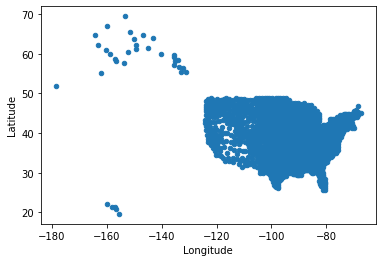

In [7]:
# Let's try to visulize the counties we have
float_degrees = lambda x: float(x.replace('°','').replace('–','-'))
df['Latitude'] = df['Latitude'].apply(float_degrees)
df['Longitude'] = df['Longitude'].apply(float_degrees)
df.plot(x='Longitude', y='Latitude', kind='scatter')

Let's just keep the mainland

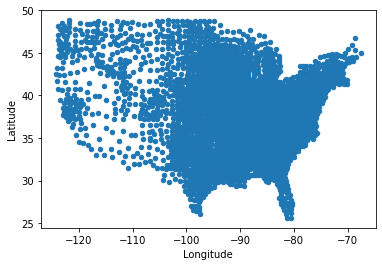

In [8]:
df = df[df['Longitude']>-130]
ax = df.plot(x='Longitude', y='Latitude', kind='scatter')

There are a lot fewer counties in the west than east.

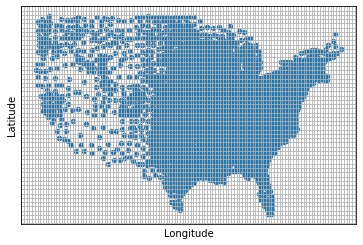

In [9]:
ax = df.plot(x='Longitude', y='Latitude', kind='scatter')
plt.tick_params(
    axis='both',
    which='both',
    bottom=False,
    left=False,
    labelleft=False,
    labelbottom=False
)
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=.5))
ax.yaxis.set_major_locator(plticker.MultipleLocator(base=.5))
plt.grid()

Above shows the .5 x .5 grid of available weather data.

In [10]:
def get_weather(fips):
    """ gather weather data per county

    Args:
        fips (str): county FIPS (id number)

    Returns:
        json: weather parameters defined in the parameter variable (see first cells)
    """
    fips_county = df[df['FIPS']==fips]
    lat, lon = fips_county['Latitude'].values[0], fips_county['Longitude'].values[0]
    base_url = r"https://power.larc.nasa.gov/api/temporal/daily/point?parameters={parameters}&community=sb&longitude={longitude}&latitude={latitude}&start={start_date}&end={end_date}&format={format}"
    api_request_url = base_url.format(parameters=','.join(params),
                                    longitude=lon, 
                                    latitude=lat,
                                    start_date = 20180101,
                                    end_date = 20230301,
                                    format = 'JSON'
                                    )
    response = requests.get(url=api_request_url, verify=True, timeout=30.00)
    return response.json()['properties']['parameter']

Let's now get drought values from https://droughtmonitor.unl.edu/WebServiceInfo.aspx#comp

In [11]:
def get_drought(fips):
    """ gather drought data per county

    Args:
        fips (str): county FIPS (id number)

    Returns:
        json: drought data from the government API
    """
    return requests.get(
        'https://usdmdataservices.unl.edu/api/CountyStatistics/GetDroughtSeverityStatisticsByAreaPercent',
        {
            'aoi': fips,
            'startdate': '1/1/2018',
            'enddate': '03/01/2023',
            'statisticsType': 1,
        }
    ).json()

In [12]:
def scrape_drought():
    """Function to scrape all the drought data for all the counties
    """
    for i, row in tqdm(df.iterrows(), total=len(df)):
        fips = row['FIPS']
        if len(str(fips)) == 4:
            str_fips = "0" + str(fips)
        else:
            str_fips = str(fips)
        if not os.path.isfile(f'data/{fips}_drought.json'):
            with open(f'data/{fips}_drought.json', 'w') as outfile:
                json.dump(get_drought(str_fips), outfile)
                
def scrape_weather():
    """Function to scrape all the weather data for all the counties
    """
    for i, row in tqdm(df.iterrows(), total=len(df)):
        fips = row['FIPS']
        if not os.path.isfile(f'data/{fips}_weather.json'):
            with open(f'data/{fips}_weather.json', 'w') as outfile:
                json.dump(get_weather(fips), outfile)

In [15]:
drought_thread = threading.Thread(target=scrape_drought)
drought_thread.start()

  0%|          | 0/3109 [00:00<?, ?it/s]

In [25]:
weather_thread = threading.Thread(target=scrape_weather)
weather_thread.start()

  0%|          | 0/3109 [00:00<?, ?it/s]

In [34]:
df.to_csv('counties.csv')

Exception in thread Thread-10:
Traceback (most recent call last):
  File "/Users/mariusmichel-nil/opt/anaconda3/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/Users/mariusmichel-nil/opt/anaconda3/lib/python3.9/threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/6f/66wfylh56w70xn5j4ssvqd1c0000gn/T/ipykernel_14674/2135002512.py", line 17, in scrape_weather
  File "/Users/mariusmichel-nil/opt/anaconda3/lib/python3.9/json/__init__.py", line 180, in dump
    fp.write(chunk)
TimeoutError: [Errno 60] Operation timed out
